# Задание 3.

* Реализовать метод решения СЛАУ, на выбор: метод вращений или метод отражений.
* Вычислить числа обусловленности.
* Протестировать на тех же матрицах, что использовались в задании 2; сравнить.

**Отчёт:** https://docs.google.com/document/d/18A57z1Lv31bYUdukDM4vbqU1SUqNmTvdOpek6cyPkh0/edit?usp=sharing

# Imports

In [1]:
from collections import namedtuple
from typing import Iterable, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nbimporter

from t01_condition_numbers import ConditionNumbers, calculate_condition_numbers
from common import generate_hilberts_matrix_element, generate_tridiagonal_matrix_element

# Solution

In [2]:
Decomposition = namedtuple('Decomposition', ['Q', 'R'])


def compute_transformation_matrix(n, i, j, A_k):
    denom = np.sqrt(A_k[i, i] ** 2 + A_k[j, i] ** 2)
    c, s = A_k[i, i] / denom, -A_k[j, i] / denom
    T = np.eye(n)
    T[[i, j], [i, j]] = c
    T[j, i] = s
    T[i, j] = -s
    
    return T


def QR_decomposition(A: np.ndarray) -> Decomposition:
    n = A.shape[0]
    Q, A_k = np.eye(n), A.copy()
    for i in range(n):
        for j in range(i + 1, n):
            T = compute_transformation_matrix(n, i, j, A_k)
            Q, A_k = Q.dot(T.T), T.dot(A_k)
    
    return Decomposition(Q, Q.T.dot(A))


def solve_Rx_v(R, v):
    n = len(v)
    x = np.zeros(n)
    for i in reversed(range(n)):
        x[i] = (v[i] - np.dot(R[i, i + 1:], x[i + 1:])) / R[i, i]
    
    return x


def solve_using_QR_decomposition(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    if not np.linalg.det(A):
        raise np.linalg.LinAlgError('Coefficient matrix is singular')

    decomposition = QR_decomposition(A)
    Q_trans_b = decomposition.Q.T.dot(b)
    
    return solve_Rx_v(decomposition.R, Q_trans_b)

# Tests

In [3]:
def test_qr_decomposition_orthogonality_of_Q():
    num_matrices = 5
    matrix_size = 100

    for _ in range(num_matrices):
        A = np.random.rand(matrix_size, matrix_size)
        Q, R = QR_decomposition(A)

        assert np.allclose(Q.T @ Q, np.eye(matrix_size)), "Q matrix should be orthogonal"
        
test_qr_decomposition_orthogonality_of_Q()

In [4]:
def test_qr_decomposition_upper_triangularity_of_R():
    num_matrices = 5
    matrix_size = 100

    for _ in range(num_matrices):
        A = np.random.rand(matrix_size, matrix_size)
        Q, R = QR_decomposition(A)

        assert np.allclose(np.triu(R), R), "R matrix should be upper triangular"

test_qr_decomposition_upper_triangularity_of_R()

In [5]:
def test_qr_decomposition_with_square_matrices():
    num_matrices = 5
    matrix_size = 100

    for _ in range(num_matrices):
        A = np.random.rand(matrix_size, matrix_size)
        Q, R = QR_decomposition(A)

        assert np.allclose(A, Q @ R), "A should be equal to the product of Q and R"

test_qr_decomposition_with_square_matrices()

In [6]:
def test_qr_decomposition_with_column_linearly_dependent_matrix():
    num_matrices = 5
    matrix_size = 100

    for _ in range(num_matrices):
        A = np.random.rand(matrix_size, matrix_size)
        A[:, -1] = A[:, 0] + A[:, 1]

        Q, R = QR_decomposition(A)

        assert np.allclose(A, Q @ R), "A should be equal to the product of Q and R in case of linearly dependent matrix"

test_qr_decomposition_with_column_linearly_dependent_matrix()

# Experiments

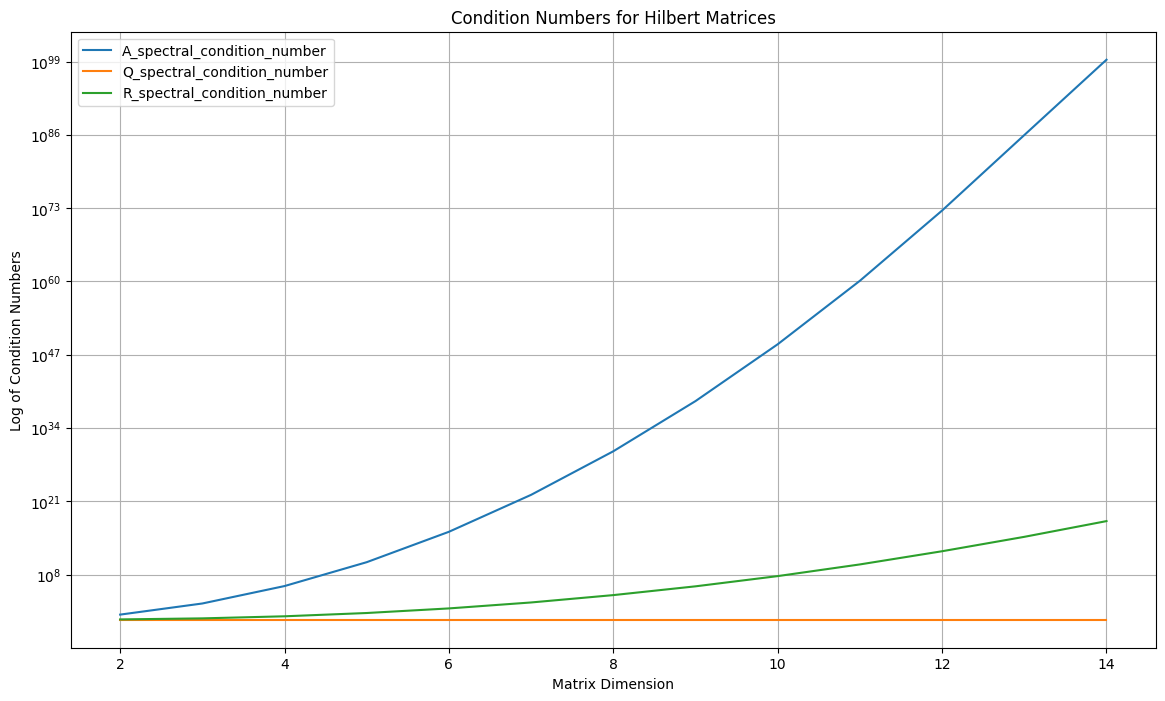

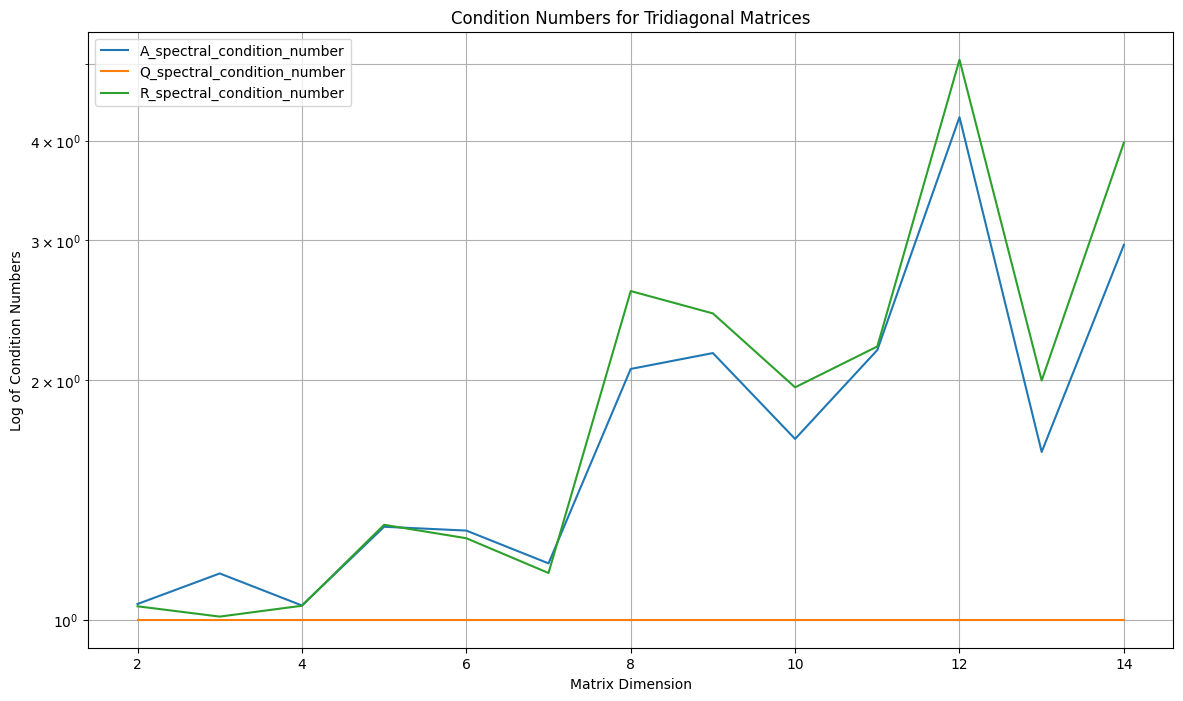

In [7]:
def experiment(dimension_range: Iterable, generate: Callable) -> pd.DataFrame:
    results = []

    for dimension in dimension_range:
        A = np.array([[generate(row, column) for column in range(dimension)] for row in range(dimension)])
        Q, R = QR_decomposition(A)
        condition_numbers_A = calculate_condition_numbers(A)
        condition_numbers_Q = calculate_condition_numbers(Q)
        condition_numbers_R = calculate_condition_numbers(R)
        
        results.append({
            'matrix_dimension': dimension,
            'A_spectral_condition_number': condition_numbers_A.volume,
            'Q_spectral_condition_number': condition_numbers_Q.volume,
            'R_spectral_condition_number': condition_numbers_R.volume,
        })

    return pd.DataFrame(results)

def plot_results(results: pd.DataFrame, title: str):
    plt.figure(figsize=(14, 8))
    for column in results.columns[1:]:
        plt.semilogy(results['matrix_dimension'], results[column], label=column)
    plt.xlabel('Matrix Dimension')
    plt.ylabel('Log of Condition Numbers')
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.show()

def run_experiments_and_plot():
    dimension_range = range(2, 15)

    # Hilbert's Matrix Experiment
    hilbert_results = experiment(dimension_range, generate_hilberts_matrix_element)
    plot_results(hilbert_results, 'Condition Numbers for Hilbert Matrices')
    
    # Tridiagonal Matrix Experiment
    tridiagonal_results = experiment(dimension_range, generate_tridiagonal_matrix_element)
    plot_results(tridiagonal_results, 'Condition Numbers for Tridiagonal Matrices')

run_experiments_and_plot()